<a href="https://colab.research.google.com/github/a-memme/Customer_Churn_and_CLTV/blob/main/CLTV_and_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import standard dependencies
import pandas as pd
import numpy as np
from datetime import datetime
from getpass import getpass
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
project = getpass('')

··········


In [3]:
#GCP connection
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
client = bigquery.Client(project=project)

In [4]:
!pip install lifetimes --upgrade

from lifetimes.utils import *
from lifetimes import BetaGeoFitter, GammaGammaFitter, ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions, plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
from lifetimes.datasets import load_dataset
from lifetimes.generate_data import beta_geometric_nbd_model
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error, confusion_matrix, mean_absolute_error, f1_score, r2_score
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00


# **Import Data**

In [5]:
sql_query = ('''
            SELECT customer_id,
                  date(created_at, "America/Toronto") created_at,
                  order_id,
                  cline.price
            FROM `ingest.shopify_orders` charge,
            UNNEST(line_items) AS cline
            WHERE TRUE
            AND customer_email IS NOT NULL
            AND sku NOT LIKE '%MEMBERSHIP%'
            ORDER BY --customer_email,
            created_at DESC;
            '''
)

eval = client.query(sql_query).to_dataframe()

# **Data Preprocessing**

## **Lifetimes Method**

In [51]:
eval['created_at'] = pd.to_datetime(eval['created_at'])

rfm = summary_data_from_transaction_data(eval, 'customer_id' , 'created_at' , 'price', freq='W')
rfm.shape

(17775, 4)

In [52]:
rfm.describe()

,frequency,recency,T,monetary_value
count,17775.000000,17775.000000,17775.000000,17775.000000
mean,0.834712,7.789986,46.475274,31.293662
std,2.418404,16.879382,15.483544,62.466007
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,39.000000,0.000000
50%,0.000000,0.000000,44.000000,0.000000
75%,1.000000,1.000000,58.000000,44.950000
max,31.000000,74.000000,74.000000,744.100000


# **Modeling & Evaluation**

## **Churn - BG/NBD Model**

In [53]:
# Establishment of the BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0001)
 #(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
        rfm['recency'],
        rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 17775 subjects, a: 0.19, alpha: 8.32, b: 0.69, r: 0.17>

In [54]:
#Summarize
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.167038,0.003901,0.159391,0.174685
alpha,8.324190,0.301375,7.733496,8.914884
a,0.186363,0.019006,0.149112,0.223614
b,0.687678,0.084357,0.522337,0.853018


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

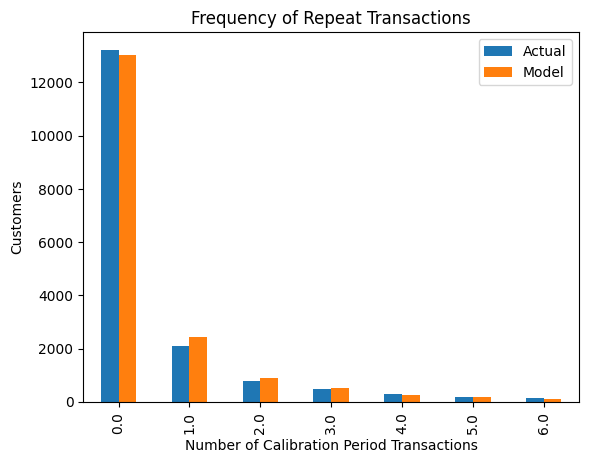

In [55]:
#Artificially generate customers with expected purchasing behaviour and compare
plot_period_transactions(bgf, max_frequency=7)

In [56]:
#Check max and min dates
print(f'Max date is {eval.created_at.max()} \n Minimum date is {eval.created_at.min()}')

Max date is 2023-08-23 00:00:00 
 Minimum date is 2022-03-25 00:00:00


MAE = 0.24472554824434903 
 RMSE = 0.47091031859375876


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

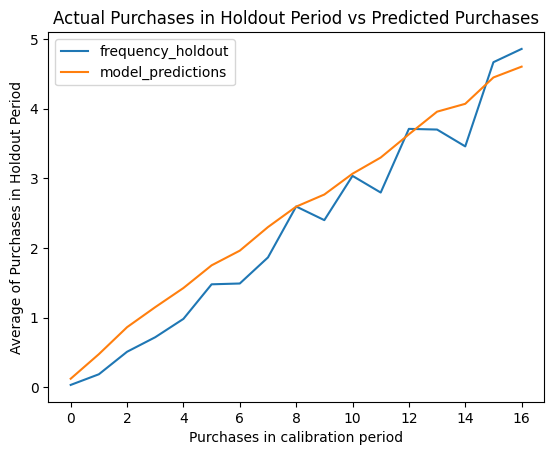

In [57]:
#Evaluation - train/test via calibration and holdout dataset
#cal_and_holdout function takes in raw dataset (not aggregated)
cal_hold = calibration_and_holdout_data(eval,
                                   'customer_id',
                                   'created_at',
                                   calibration_period_end='2023-03-21', #1 year calibration (train)
                                   observation_period_end='2023-07-21', #4 months (16 weeks) holdout (predict)
                                   freq = 'W')

eval_model = BetaGeoFitter(penalizer_coef=0.1)
eval_model.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])

#Expected number of future transactions in the next 3 time periods by calibration/holdout model
cal_hold['predicted_purchases_3'] = eval_model.predict(12, cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])

#Calculate MAE and RMSE
mae = mean_absolute_error(cal_hold['frequency_holdout'], cal_hold['predicted_purchases_3'])
rmse = mean_squared_error(cal_hold['frequency_holdout'], cal_hold['predicted_purchases_3'], squared=False)
print(f'MAE = {mae} \n RMSE = {rmse}')

#Visualize
plot_calibration_purchases_vs_holdout_purchases(eval_model, cal_hold, n=17)

In [58]:
#Store frequency prediction of 1 year (52 weeks)
rfm['freq_pred_annual'] = bgf.predict(52, rfm['frequency'],rfm['recency'], rfm['T'])

## **CLTV - Gamma Gamma Model**

In [59]:
#Remove frequencies and monetary values that aren't greater than 0 (i.e single purchases)
rfm = rfm[rfm['monetary_value'] > 0]
rfm = rfm[rfm['frequency'] > 0]

#Check for (lack of) correlation between frequency and monetary value columns
rfm[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,-0.015069
monetary_value,-0.015069,1.000000


In [60]:
#Configure model and fit
ggf = GammaGammaFitter(penalizer_coef=0.001)

ggf.fit(rfm['frequency'], rfm['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4543 subjects, p: 12.92, q: 1.91, v: 12.39>

In [61]:
#Summarize
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,12.916537,0.217001,12.491215,13.341859
q,1.905748,0.037509,1.832230,1.979267
v,12.392189,0.217332,11.966219,12.818160


In [62]:
#Compare predicted monetary avgs vs actual monetary avgs
predict_monetary = ggf.conditional_expected_average_profit(rfm['frequency'], rfm['monetary_value'])
rfm['predicted_monetary'] = predict_monetary

actual_monetary = rfm['monetary_value']
#actual_monetary = actual_monetary.fillna(0)

#Visualize distribution plot
import plotly.figure_factory as ff

x3= predict_monetary
x4= actual_monetary

hist_data2 = [x3, x4]
groups2 = ['Prediction', 'Actual']

#Calculate MAE and RMSE
mae = mean_absolute_error(actual_monetary, predict_monetary)
rmse = mean_squared_error(actual_monetary, predict_monetary, squared=False)

print(f'MAE = {mae} \n RMSE = {rmse}')

fig2=ff.create_distplot(hist_data2, groups2, bin_size=9)
fig2.show()

MAE = 3.132866672775503 
 RMSE = 4.232816620193813


# **Analysis**

## **Calculating Probabilities & CLTV**

In [63]:
rfm['retention'] = bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'],rfm['T'])
rfm['churn'] = 1 - bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'],rfm['T'])
rfm['annual_cltv'] = ggf.customer_lifetime_value(bgf,
                                          rfm['frequency'],
                                          rfm['recency'],
                                          rfm['T'],
                                          rfm['monetary_value'],
                                          time = 12, #cltv for 1 year
                                          freq='W',#T calculated in weeks for our model
                                          discount_rate = 0.01 #sample discount rate
                                          )
rfm['qrtly_cltv'] = ggf.customer_lifetime_value(bgf,
                                          rfm['frequency'],
                                          rfm['recency'],
                                          rfm['T'],
                                          rfm['monetary_value'],
                                          time = 4, #cltv predicting 4 months
                                          freq='W',#T calculated in weeks for our model
                                          discount_rate = 0.01 #sample discount rate
                                          )

In [64]:
analyze = rfm.copy()
analyze.reset_index(inplace=True)
analyze.drop(columns='customer_id', inplace=True)
analyze

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv
0,2.0,29.0,67.0,149.800000,0.938104,150.711897,0.664141,0.335859,133.085356,47.771687
1,1.0,33.0,61.0,89.900000,0.548874,95.589174,0.668600,0.331400,49.392041,17.797912
2,12.0,49.0,71.0,155.805000,4.139896,155.926511,0.546488,0.453512,607.578417,217.355440
3,14.0,69.0,72.0,86.532143,8.517854,86.981626,0.977186,0.022814,697.342873,249.372676
4,2.0,56.0,64.0,124.850000,1.285255,126.607051,0.875380,0.124620,153.176239,55.043494
...,...,...,...,...,...,...,...,...,...,...
4538,1.0,10.0,11.0,38.210000,2.074071,47.286323,0.776192,0.223808,92.442393,34.904591
4539,1.0,1.0,8.0,44.950000,2.043439,53.584663,0.657470,0.342530,103.227647,39.252692
4540,1.0,1.0,6.0,44.950000,2.412452,53.584663,0.690951,0.309049,121.886824,46.601812
4541,1.0,1.0,4.0,73.900000,2.900164,80.637624,0.727123,0.272877,220.541801,84.849200


In [65]:
analyze.describe()

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv
count,4543.000000,4543.000000,4543.000000,4543.000000,4543.000000,4543.000000,4543.000000,4543.000000,4543.000000,4543.000000
mean,3.265683,30.478979,56.499230,122.439983,1.973995,124.677448,0.670191,0.329809,220.553171,79.348439
std,3.866108,20.573063,14.342816,64.086770,2.525297,61.097419,0.210634,0.210634,323.632734,116.043130
min,1.000000,1.000000,2.000000,19.900000,0.072053,25.212118,0.005174,0.006036,4.888100,1.755390
25%,1.000000,12.000000,44.000000,89.900000,0.489488,92.840944,0.514933,0.138708,54.307477,19.751547
50%,2.000000,28.000000,60.000000,104.850000,0.912427,106.524127,0.669756,0.330244,103.754252,37.421862
75%,4.000000,48.000000,70.000000,139.800000,2.207761,142.219321,0.861292,0.485067,249.672429,90.015314
max,31.000000,74.000000,74.000000,744.100000,19.069284,732.967847,0.993964,0.994826,6950.237605,2508.167803


In [76]:
best_churn = getpass()

··········


<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

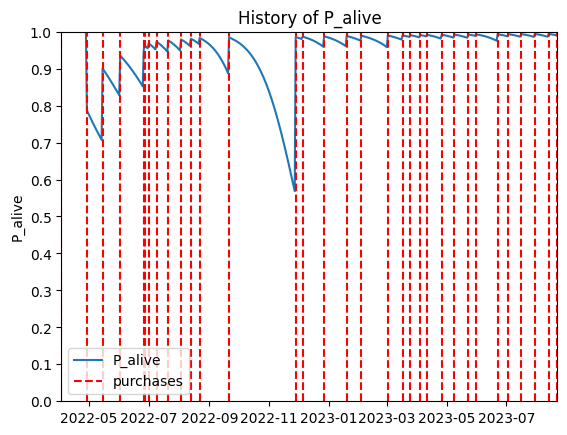

In [82]:
# Visualize the best retention customer's retention/drop-off lifetime
best_retention = eval.loc[eval['customer_id'].isin([int(best_churn)])]
plot_history_alive(bgf, 74, best_retention, 'created_at')

In [84]:
worst_churn = getpass()

··········


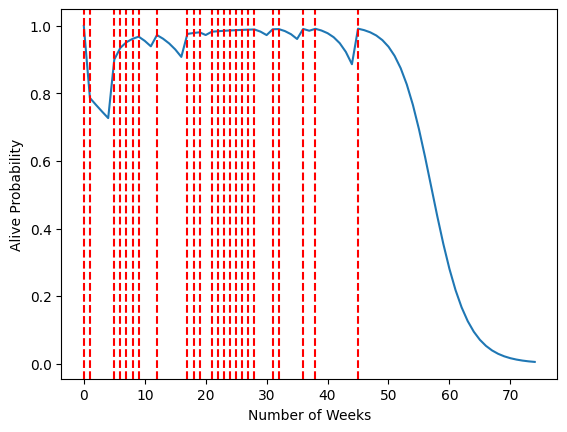

In [85]:
#Manually recreate the visual above for the customer with the worst retention probability (standard function doesn't allow for the time window to extend beyond the last purchase)

#Filter for worst candidate
worst_retention = eval.loc[eval['customer_id'].isin([int(worst_churn)])]
copy = worst_retention.copy()

#Create a new df resampling and ranking weeks - values that are not NA will be times of purchase
copy.set_index('created_at', inplace=True)
worst_weekly = copy.resample('W').mean()
worst_weekly.reset_index(inplace=True)
worst_weekly['weekly_rank'] = worst_weekly.index
worst_weekly.dropna(inplace=True)

# Store numbered weeks where purchases occured in a list
weekly_purchases = worst_weekly['weekly_rank'].to_list()

#Calculate probabilities and Visualize
worst_p_path = calculate_alive_path(bgf, worst_retention, 'created_at', 74, 'W')

plt.plot(worst_p_path)
plt.xlabel('Number of Weeks')
plt.ylabel('Alive Probability')

for line in weekly_purchases:
    plt.axvline(x=line, color='red', linestyle='--')

plt.show()

## **Distributions**

In [86]:
#Visualize churning distribution
fig = px.histogram(analyze, x='churn', nbins=10)
fig.show()

In [95]:
#Understand recency/tenure/freq profiles customers in the 0-10% churn bin
analyze['weeksfrom_lastpurchase'] = analyze['T'] - analyze['recency']
analyze.loc[analyze['churn'] <= 0.1, ['frequency', 'recency', 'T', 'weeksfrom_lastpurchase', 'monetary_value', 'churn', 'annual_cltv', 'qrtly_cltv']].sort_values(['T'], ascending=True).head(15)

,frequency,recency,T,weeksfrom_lastpurchase,monetary_value,churn,annual_cltv,qrtly_cltv
4527,4.0,11.0,14.0,3.0,25.712500,0.084424,206.627205,77.192152
4529,3.0,14.0,15.0,1.0,39.950000,0.073785,231.881490,86.536441
4518,3.0,17.0,20.0,3.0,41.616667,0.089956,197.938791,73.310224
4493,4.0,22.0,25.0,3.0,33.712500,0.069659,185.692543,68.312585
888,4.0,23.0,26.0,3.0,33.712500,0.068885,180.824840,66.450227
4489,6.0,25.0,26.0,1.0,57.433333,0.037832,450.153385,165.311748
4409,3.0,27.0,28.0,1.0,56.600000,0.070415,213.301320,78.272562
4471,4.0,27.0,28.0,1.0,72.162500,0.053721,356.484340,130.735679
4466,8.0,28.0,29.0,1.0,59.931250,0.029373,576.909065,211.155624
2634,5.0,26.0,29.0,3.0,66.720000,0.057756,396.259609,145.126469


## **Segmentation**

In [100]:
#Segment customers by retention probability
analyze['retention_segment'] = pd.qcut(analyze['retention'],4,['D','C','B','A'])

#Sort D group by cltv highest to lowest to understand which customers best to target
analyze[analyze['retention_segment'] == 'D'].sort_values(['annual_cltv'], ascending=False).head(20)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,retention_segment,weeksfrom_lastpurchase
3653,22.0,49.0,64.0,193.979545,6.068552,193.924708,0.402367,0.597633,1107.732195,397.101136,D,15.0
3293,15.0,51.0,72.0,180.453333,4.133457,180.435963,0.442910,0.557090,701.980092,251.023321,D,21.0
2752,3.0,12.0,39.0,446.066667,1.597406,439.914661,0.497981,0.502019,661.703447,240.622460,D,27.0
11,6.0,36.0,72.0,274.700000,1.661352,273.568121,0.438269,0.561731,427.781716,153.063615,D,36.0
3734,10.0,36.0,59.0,136.650000,3.151854,136.929029,0.425851,0.574149,406.259867,145.966475,D,23.0
4482,3.0,6.0,28.0,233.000000,1.768862,231.714544,0.430870,0.569130,386.038407,141.659767,D,22.0
2452,9.0,44.0,73.0,160.955556,2.507337,161.077437,0.450027,0.549973,380.132883,135.929554,D,29.0
799,3.0,12.0,40.0,239.733333,1.514332,238.294085,0.481433,0.518567,339.786609,123.476330,D,28.0
3499,14.0,48.0,73.0,144.650000,2.477043,144.809833,0.287558,0.712442,337.611177,120.694969,D,25.0
3120,4.0,29.0,68.0,259.675000,1.346500,258.245794,0.501043,0.498957,327.306366,117.316115,D,39.0


In [102]:
#Alternatively, find the most valuable customers with the highest churning probability (>=80%)
analyze[analyze['churn'] >= 0.8].sort_values(['annual_cltv'], ascending=False).head(10)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,retention_segment,weeksfrom_lastpurchase
2972,14.0,45.0,74.0,182.521429,1.150976,182.492517,0.135189,0.864811,197.693842,70.654181,D,29.0
4116,3.0,4.0,43.0,299.800000,0.404099,296.988798,0.135949,0.864051,112.999845,40.984429,D,39.0
2976,8.0,34.0,74.0,141.062500,0.748833,141.372339,0.152658,0.847342,99.640306,35.622190,D,40.0
1986,8.0,31.0,67.0,93.650000,0.905637,94.371817,0.169583,0.830417,80.446500,28.823691,D,36.0
1983,11.0,39.0,71.0,79.900000,1.056863,80.513304,0.152017,0.847983,80.090309,28.652916,D,32.0
2587,3.0,13.0,73.0,233.000000,0.330650,231.714544,0.172122,0.827878,72.114624,25.816833,D,60.0
3983,4.0,10.0,46.0,97.400000,0.653196,98.766591,0.176032,0.823968,60.740380,21.980223,D,36.0
635,2.0,7.0,72.0,229.600000,0.265645,227.808759,0.199953,0.800047,56.961946,20.412512,D,65.0
23,5.0,21.0,68.0,106.660000,0.507317,107.628981,0.152171,0.847829,51.394917,18.416495,D,47.0
1092,4.0,6.0,46.0,207.300000,0.263883,206.773150,0.071115,0.928885,51.372317,18.590186,D,40.0


In [104]:
#Sort A group by cltv highest to lowest to understand most valuable consumers
analyze[analyze['retention_segment'] == 'A'].sort_values(['annual_cltv'], ascending=False).head(15)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,retention_segment,weeksfrom_lastpurchase
3741,12.0,47.0,49.0,736.218333,10.072153,732.967847,0.976026,0.023974,6950.237605,2508.167803,A,2.0
2898,26.0,68.0,68.0,288.840385,16.791041,288.538805,0.992797,0.007203,4560.183565,1632.435118,A,0.0
1469,31.0,72.0,72.0,244.848387,19.069284,244.694627,0.993964,0.006036,4391.819999,1570.130035,A,0.0
1491,23.0,65.0,71.0,248.219565,13.733078,248.002239,0.951650,0.048350,3205.630910,1146.487394,A,6.0
294,15.0,69.0,72.0,349.355333,9.126230,348.552041,0.977898,0.022102,2993.969299,1070.623119,A,3.0
2964,21.0,72.0,73.0,226.261905,12.724795,226.097026,0.988430,0.011570,2707.878149,967.909989,A,1.0
280,20.0,63.0,66.0,218.362500,13.083629,218.217006,0.978734,0.021266,2687.359716,962.727878,A,3.0
3408,19.0,61.0,62.0,212.492105,13.219836,212.360568,0.987047,0.012953,2642.563095,948.045936,A,1.0
172,27.0,68.0,71.0,166.376296,16.593435,166.403092,0.980485,0.019515,2598.885924,929.446143,A,3.0
120,28.0,72.0,73.0,159.978929,16.971609,160.020751,0.990553,0.009447,2556.123864,913.594904,A,1.0
